# 3. 비지도학습 알고리즘 (차원축소, 군집분석, 연관규칙분석)

## [연습문제]

### 1. 다음은 신용 카드 사용자 데이터이다. 데이터는 신용카드 사용 행태를 나타내는 입력 변수들 구성되어 있다. 데이터 컬럼 정의서는 아래와 같을 때, 2개의 군집 분석 알고리즘으로 각각 군집을 생성하고 군집 생성 과정을 설명하시오. (데이터 링크는 아래 코드 참조)
> 1. CUST_ID: 신용카드 사용자 ID
> 2. BALANCE: 구매 계좌 잔액
> 3. BALANCE_FREQUENCY: 구매 계좌 잔액이 업데이트 되는 빈도 지수, 0(자주 업데이트되지 않음)~1(자주 업데이트 됨) 
> 4. PURCHASES: 구매 계좌로부터의 구매액
> 5. PURCHASES_FREQUENCY: 구매 빈도 지수, 0(자주 구매하지 않음)~1(자주 구매함) 6. PURCHASES_TRX: 구매 거래 건수

In [1]:
from pandas import read_csv
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice10_credit_card.csv')
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
0  C10001    40.900749           0.818182      95.40             0.166667   
1  C10002  3202.467416           0.909091       0.00             0.000000   
2  C10003  2495.148862           1.000000     773.17             1.000000   
3  C10004  1666.670542           0.636364    1499.00             0.083333   
4  C10005   817.714335           1.000000      16.00             0.083333   

   PURCHASES_TRX  
0              2  
1              0  
2             12  
3              1  
4              1  


In [3]:
# 데이터 전처리: CUST_ID는 범주형 변수로서 각 고객을 식별할 뿐이기 때문에 군집 분석에서는 제외하였다. 그 후, 변수 간 스케일 차이로 인한 왜곡이 일어나지 않도록 표준화를 진행하였다.
from pandas import DataFrame
df2 = df.drop('CUST_ID', axis=1)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled = DataFrame(ss.fit_transform(df2), columns=df2.columns)
# K-means 클러스터링과 혼합분포 군집 알고리즘으로 각각 군집을 생성하고자 한다.

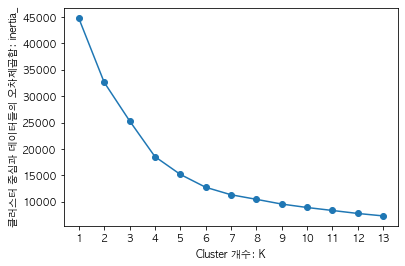

In [7]:
# K-means는 후보 군집 개수에 따른 오차제곱합들을 살펴, scree plot을 통해 elbow 방법으로 오차제곱합이 평평해지기 시작하는 지점의 군집 개수로 데이터를 군집화하고자 한다. 
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
from sklearn.cluster import KMeans
from collections import Counter
I = [] # 오차제곱합
for k in range(1,14):
    kmeans=KMeans(n_clusters=k).fit(scaled)
    I.append(kmeans.inertia_) # 오차제곱합
plt.plot(list(range(1,14)), I, marker="o")
plt.xticks(list(range(1,14)), list(range(1,14)))
plt.xlabel("Cluster 개수: K")
plt.ylabel("클러스터 중심과 데이터들의 오차제곱합: inertia_")
plt.show()
# 팔꿈치 지점으로 보이는 4를 군집의 개수로 정하기로 한다.

In [8]:
# n_cluster=4로 군집화
Kmodel = KMeans(n_clusters=4, random_state=0)
Kmodel.fit(scaled) # 해당 열 데이터의 각 cluster center와의 거리
kmeans_result = Kmodel.labels_ # 각 데이터의 군집 반환
print(Counter(kmeans_result))

# 타당성 평가
from sklearn.metrics import silhouette_score
print("실루엣 계수: %.3f" %silhouette_score(scaled, kmeans_result))

Counter({2: 3604, 0: 3478, 1: 1485, 3: 383})
실루엣 계수: 0.422


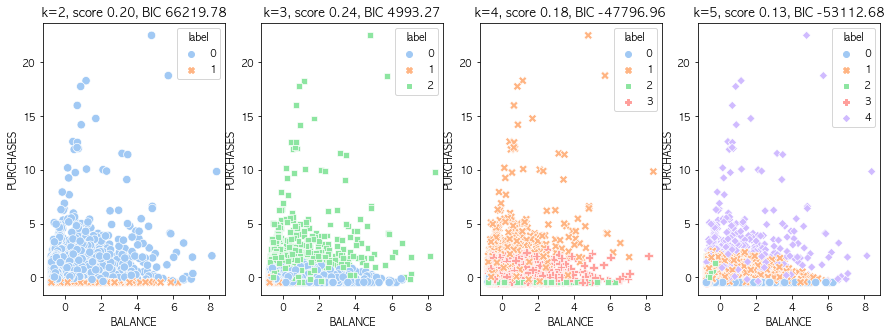

In [11]:
# 혼합분포군집 방법으로는 분포 개수 후보군으로 적합한 각각의 결과를 실루엣 계수와 BIC로 비교하고 가장 타당한 분포 개수를 정하고자 한다.
from sklearn.mixture import GaussianMixture
import seaborn as sns
dist_list =[2,3,4,5]
fig, axes = plt.subplots(1,4, figsize = (15,5))
for ax, k in zip(axes, dist_list):
    gm = GaussianMixture(n_components=k, covariance_type='full').fit(scaled)
    temp_df = scaled.copy()
    temp_df['label']= gm.predict(scaled)
    sns.scatterplot(x='BALANCE', y='PURCHASES', data=temp_df, hue='label', style='label', s=70, ax=ax, palette='pastel')
    aic, bic = gm.aic(scaled), gm.bic(scaled)
    score = silhouette_score(scaled, temp_df['label'])
    ax.set_title("k={}, score {:.2f}, BIC {:.2f}".format(k, score, bic))
plt.show()
# 비교적 실루엣 스코어가 높고, BIC가 낮은 것으로 보이는 분포 개수 4개로 정하기로 한다.

In [12]:
# n_components=4로 군집화
Gmodel = GaussianMixture(n_components=4)
Gmodel.fit(scaled)
GM_result = Gmodel.predict(scaled)
print(Counter(GM_result))

# 타당성 평가
from sklearn.metrics import silhouette_score
print("실루엣 계수: %.3f" %silhouette_score(scaled, GM_result))

Counter({2: 4496, 1: 2040, 3: 1426, 0: 988})
실루엣 계수: 0.175


### 2. 두 모델을 비교하고, 더 타당한 모델을 선택하시오.

In [ ]:
# 두 분포 모두 각 군집 별 데이터의 개수는 고르게 배치된 것으로 보이지만, 실루엣 계수로 미루어볼 때 군집 내의 응집도와 군집 간 분리도가 더 높은 K-means(0.422)의 결과가 혼합분포군집(0.175)의 결과보다 더 타당한 것으로 보인다. 이에 K-means 모델을 선택하고자 한다.

### 3. 선택한 모델로 생성한 군집들의 고객 특성을 분석하시오.

In [1052]:
df['cluster'] = kmeans_result
print(df[df['cluster']==0].describe().round(2).iloc[:, :-1])
# 군집0은 3478개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 2397에, 계좌 업데이트 빈도지수 평균이 0.98이며, 구매액 평균이 230.47이고, 구매 빈도지수 평균은 0.13이고, 거래 건수 평균은 2.38의 특성을 보인다.
# 해당 군집은 구매계좌 잔액과 계좌 업데이트 빈도지수는 높은 편이지만, 실제 구매는 많이 이루어지지 않는 군집이다. '잠재 구매력 고객'으로 정의할 수 있다.

        BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count   3478.00            3478.00    3478.00              3478.00   
mean    2397.40               0.98     230.47                 0.13   
std     2281.64               0.06     465.86                 0.18   
min        0.49               0.55       0.00                 0.00   
25%      924.57               1.00       0.00                 0.00   
50%     1603.21               1.00       0.52                 0.08   
75%     3098.06               1.00     255.61                 0.25   
max    16304.89               1.00    4900.00                 1.00   

       PURCHASES_TRX  
count        3478.00  
mean            2.38  
std             3.85  
min             0.00  
25%             0.00  
50%             1.00  
75%             4.00  
max            34.00  


In [1049]:
print(df[df['cluster']==1].describe().round(2).iloc[:, :-1])
# 군집1은 1485개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 155.46에, 계좌 업데이트 빈도지수 평균이 0.40이며, 구매액 평균이 353.70이고, 구매 빈도지수 평균은 0.28이고, 거래 건수 평균은 4.45의 특성을 보인다.
# 해당 군집은 구매계좌 잔액과 계좌 업데이트 빈도가 낮고, 구매액과 구매빈도도 낮은 '낮은 구매력 고객'으로 정의할 수 있다.

       BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count  1485.00            1485.00    1485.00              1485.00   
mean    155.46               0.40     353.70                 0.28   
std     333.71               0.20     529.36                 0.27   
min       0.00               0.00       0.00                 0.00   
25%       7.58               0.27      33.38                 0.08   
50%      29.47               0.45     161.50                 0.18   
75%     131.34               0.55     442.03                 0.42   
max    3947.75               0.75    5252.04                 1.00   

       PURCHASES_TRX  
count        1485.00  
mean            4.45  
std             5.22  
min             0.00  
25%             1.00  
50%             3.00  
75%             6.00  
max            41.00  


In [1050]:
print(df[df['cluster']==2].describe().round(2).iloc[:, :-1])
# 군집2는 3604개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 1084.17에, 계좌 업데이트 빈도지수 평균이 0.97이며, 구매액 평균이 1316.54이고, 구매 빈도지수 평균은 0.87이고, 거래 건수 평균은 21.97의 특성을 보인다.
# 전체 고객의 40%가 군집 2에 해당할 만큼 일반적인 군집 특성을 가진다. 구매계좌 잔액과 구매액은 일반적이지만 계좌 업데이트 빈도는 매우 높고, 구매 빈도지수도 높은 편이며, 거래 건수도 높은 편에 속한다. "높은 구매력 고객"으로 정의할 수 있다.

        BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count   3604.00            3604.00    3604.00              3604.00   
mean    1084.17               0.97    1316.54                 0.87   
std     1450.10               0.08    1166.23                 0.16   
min        0.73               0.45       8.40                 0.25   
25%      111.73               1.00     462.96                 0.75   
50%      483.33               1.00     938.08                 0.92   
75%     1464.57               1.00    1840.17                 1.00   
max    11734.27               1.00    8591.31                 1.00   

       PURCHASES_TRX  
count        3604.00  
mean           21.97  
std            14.68  
min             0.00  
25%            12.00  
50%            17.00  
75%            28.00  
max            98.00  


In [1051]:
print(df[df['cluster']==3].describe().round(2).iloc[:, :-1])
# 군집3은 383개의 고객이 해당되는 군집으로서 구매계좌 잔액 평균 3983.54에, 계좌 업데이트 빈도지수 평균이 0.99이며, 구매액 평균이 7590.20이고, 구매 빈도지수 평균은 0.96이고, 거래 건수 평균은 98.16의 특성을 보인다.
# 군집3은 4개의 군집 중에서 고객수는 가장 적지만, 구매계좌 사용, 구매액, 구매빈도, 거래건수가 가장 높고 활발한 '슈퍼 구매력 고객'이라고 정의할 수 있다.

        BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
count    383.00             383.00     383.00               383.00   
mean    3983.54               0.99    7590.20                 0.96   
std     3431.34               0.05    6288.93                 0.13   
min      137.64               0.27     885.44                 0.17   
25%     1216.19               1.00    4121.02                 1.00   
50%     2986.42               1.00    5779.36                 1.00   
75%     5768.60               1.00    8731.10                 1.00   
max    19043.14               1.00   49039.57                 1.00   

       PURCHASES_TRX  
count         383.00  
mean           98.16  
std            54.14  
min             3.00  
25%            67.50  
50%            87.00  
75%           114.00  
max           358.00  


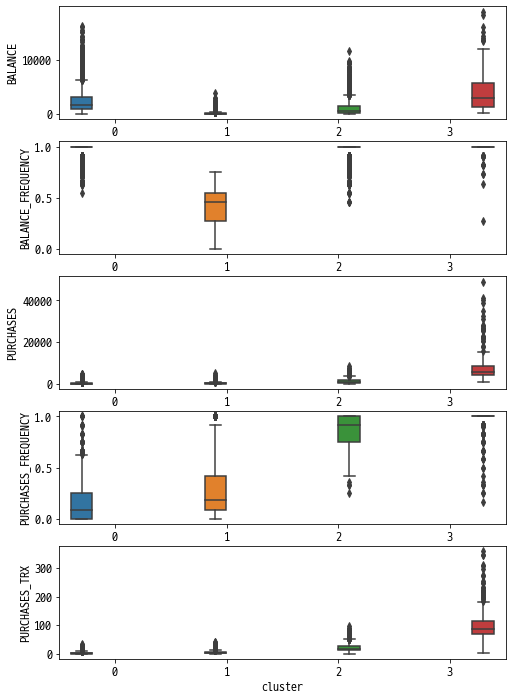

In [1043]:
# 특성 별 각 군집의 데이터 분포는 아래와 같이 시각화 할 수 있다.
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8,12)
plt.rcParams['font.family'] = 'D2Coding'
fig, axes = plt.subplots(5,1)
for ax, col in zip(axes, ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'PURCHASES_FREQUENCY', 'PURCHASES_TRX']):
    sns.boxplot(x='cluster', y=col, hue='cluster', data=df, ax=ax)
    ax.legend().remove()
plt.show()

### 4. 고객 특성이 다음과 같다면 어느 군집으로 분류하는 것이 타당한지 서술하시오.
>  BALANCE: 3000, BALANCE_FREQUENCY: 1,
PURCHASES: 6000, PURCHASES_FREQUENCY: 1, PURCHASES_TRX: 100

In [1032]:
# 주어진 데이터를 앞서 표준화한 기준으로 정규화하고, 적합한 군집 모델로 예측한 결과 군집 3이 나왔다.
Kmodel.predict(ss.transform([[3000, 1, 6000, 1, 100]]))

array([3], dtype=int32)

### 5. 각 군집들을 대상으로 마케팅 전략을 수립하시오.

In [ ]:
# 여러 군집들 중에서도 군집 0을 메인 타겟으로 한 마케팅 전략을 제안한다. 군집 0에 해당하는 고객들은 전체의 39%를 차지하여 규모가 클 뿐만 아니라, 구매계좌 잔액, 계좌 업데이트 빈도 지수를 미루어보아 구매력이 높은 집단으로 판단되기 때문이다. 다만, 현재 해당 군집의 구매액, 구매 빈도, 거래 건수가 낮은 이유는 해당 군집들이 필요로하는 제품의 라인업이 부족하거나 구매 과정 상의 동선, 프로모션 부족 등의 문제가 있을 것으로 예상한다. 이러한 문제점을 파악하여 제품 라인업을 보충하고, 구매 과정 상의 동선을 확인하거나 해당 군집을 대상으로 한 프로모션을 기획하기를 제안한다.

## [기출문제]

# 과제 1. 구매데이터 군집분석 문제  
[데이터 설명]
> - nvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
> - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
> - Description: Product (item) name. Nominal.
> - Quantity: The quantities of each product (item) per transaction. Numeric.
> - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
> - UnitPrice: Unit price. Numeric, Product price per unit in sterling.
> - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
> - Country: Country name. Nominal, the name of the country where each customer resides.
- ADP 실기 26회 기출문제: https://www.datamanim.com/dataset/ADPpb/00/26.html

### 1-1. 결측치를 확인하고, 결측치 제거할 것

In [27]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium
3,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,14646.0,Netherlands
4,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,12583.0,France


In [28]:
df.isna().sum()
# Quantity에서 25개, UnitPrice에서 97개의 결측치가 확인되었다.

InvoiceNo       0
StockCode       0
Description     0
Quantity       25
InvoiceDate     0
UnitPrice      97
CustomerID      0
Country         0
dtype: int64

In [29]:
# 전체 데이터 35801개 대비 결측치의 개수가 미비하여 삭제해도 무방할 것으로 판단한다.
df = df[(df['Quantity'].isna()==False) & (df['UnitPrice'].isna()==False)].reset_index(drop=True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 1-2. 이상치 제거하는 방법을 설명하고, 이상치 제거하고 난 결과를 통계적으로 나타낼 것

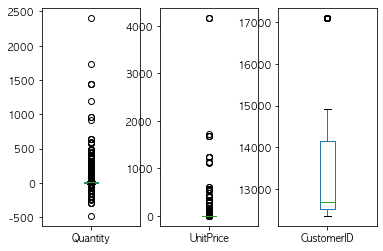

In [30]:
# 이상치를 제거하는 방법으로는 이상치 경계값을 벗어나는 값들을 절단하는 방법, 이상치 경계값으로 조정하는 방법 등이 있다. 이상치 제거는 수치형 변수에 대해서 실행할 수 있는데 CustomerID는 수치형 변수가 아닌 범주형 변수로 보는 것이 해석이 타당하므로, Quantity와 UnitPrice에 대해서 이상치를 확인하고 경계값으로 조정하기로 한다.
plt.rcParams['axes.unicode_minus'] = False
df['CustomerID'] = df['CustomerID'].astype('object')

from matplotlib import pyplot as plt
df.plot(kind='box', subplots=True)
plt.show()

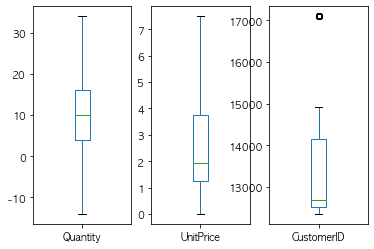

이상치 조정 전
           Quantity     UnitPrice
count  35679.000000  35679.000000
mean      18.436475      4.612573
std       42.203163     48.099265
min     -480.000000      0.000000
25%        4.000000      1.250000
50%       10.000000      1.950000
75%       16.000000      3.750000
max     2400.000000   4161.060000 

이상치 조정 후
           Quantity    UnitPrice
count  35679.000000  35679.00000
mean      12.079234      2.75625
std       10.139938      2.24842
min      -14.000000      0.00000
25%        4.000000      1.25000
50%       10.000000      1.95000
75%       16.000000      3.75000
max       34.000000      7.50000


In [31]:
# 조정 후 결과
df2 = df.copy()
for feat in ['Quantity', 'UnitPrice']:
    IQR = df2[feat].quantile(0.75) - df2[feat].quantile(0.25)
    down = df2[feat].quantile(0.25) - IQR * 1.5
    up = df2[feat].quantile(0.75) + IQR * 1.5
    df2[feat] = df2[feat].clip(down, up)
df2.plot(kind='box', subplots=True)
plt.show()

print("이상치 조정 전")
print(df[['Quantity', 'UnitPrice']].describe(), "\n")

print("이상치 조정 후")
print(df2[['Quantity', 'UnitPrice']].describe())
# 이상치 조정 전 대비 조정 후에 최솟값과 최댓값의 극단적인 값이 사라짐을 확인할 수 있고, 표준편차가 줄어들었음을 알 수 있다. 사분위수들은 이상치 처리와 상관없이 동일하다.

### 1-3. F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 군집분석 방법들 중 택2 하여 군집을 생성할 것, 군집을 생성한 과정을 각각 설명할 것

In [37]:
df2['amount'] = df2['Quantity']*df2['UnitPrice']
df2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany,11.70
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE,15.00
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium,15.00
3,541711,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,24.0,1/21/2011 11:18,1.25,14646.0,Netherlands,30.00
4,554134,21154,RED RETROSPOT OVEN GLOVE,10.0,5/23/2011 9:48,1.25,12583.0,France,12.50
...,...,...,...,...,...,...,...,...,...
35674,554137,21668,RED STRIPE CERAMIC DRAWER KNOB,12.0,5/23/2011 10:13,1.25,12708.0,Germany,15.00
35675,572986,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,6.0,10/27/2011 10:51,3.25,12681.0,France,19.50
35676,579927,22734,SET OF 6 RIBBONS VINTAGE CHRISTMAS,6.0,12/1/2011 9:20,2.89,12572.0,Germany,17.34
35677,551163,22431,WATERING CAN BLUE ELEPHANT,1.0,4/26/2011 15:52,1.95,12573.0,France,1.95


In [40]:
df3 = DataFrame(df2.groupby('CustomerID').count()['InvoiceNo'].values, columns=['F'])
df3['M'] = df2.groupby('CustomerID').sum()['amount'].values
df3

,F,M
0,57,1001.15
1,59,2191.92
2,131,5424.29
3,10,182.40
4,272,4702.51
...,...,...
284,228,3710.70
285,63,459.38
286,2082,103920.19
287,5875,112507.61


In [41]:
# K-means와 DB-SCAN으로 군집을 생성하고자 한다. 거리 기반 모델이기 때문에 변수들의 척도 차이를 제거하기 위해 스케일링을 진행하여 군집을 생성하기로 한다.
# feature scaling
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
ss = StandardScaler()
scaled = ss.fit_transform(df3)
df4 = DataFrame(scaled, columns=df3.columns)
df4.head(3)

,F,M
0,-0.173907,-0.174434
1,-0.168674,-0.050654
2,0.019740,0.285350


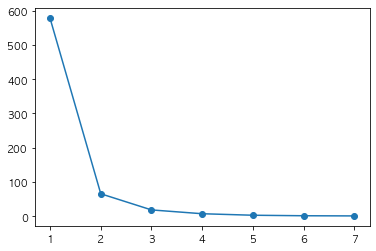

In [42]:
# K-means modeling: 적정한 군집의 개수를 정하기 위해 오차제곱합의 평균으로 엘보우 플롯을 그려서 비교
from sklearn.cluster import KMeans
I = [] #오차제곱합
for k in range(1,8):
    kmeans = KMeans(n_clusters=k).fit(df4)
    I.append(kmeans.inertia_/k) # 오차제곱합의 평균
plt.plot(list(range(1,8)), I, marker='o')
plt.show()
# 군집의 개수를 3으로 선정하였다.

model = KMeans(n_clusters=3).fit(df4)
kmeans_label = model.labels_

In [47]:
# DB-SCAN modeling: 적정한 군집의 개수를 정하기 위해 eps 후보군들의 군집 결과를 시각화 하고, 실루엣 계수로 결과를 비교
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
eps_list = [0.5, 1, 5, 10]
for eps in eps_list:
    db = DBSCAN(eps=eps, min_samples=100).fit(df4)
    score = silhouette_score(df4, db.labels_)
    print("cluster 개수 ", len(np.unique(db.labels_)))
    print("eps {:.1f}, score {:.3f}".format(eps, score), "\n")

model = DBSCAN(eps = 4, min_samples=100).fit(df4)
db_label = model.labels_

cluster 개수  2
eps 0.5, score 0.867 

cluster 개수  2
eps 1.0, score 0.962 

cluster 개수  2
eps 5.0, score 0.968 

cluster 개수  2
eps 10.0, score 0.969 



### 1-4. 둘 중에 한 모델을 선택하고, 그 이유를 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

In [48]:
# 군집 내의 응집도와 순집 간 분리도를 이용한 지표로 실루엣 계수가 있다. 이 계수는 군집 내 요소 간의 거리가 짧고 서로 다른 군집 간 거리가 멀수록 값이 커진다. 완벽한 군집화는 1, 군집화가 전혀 이루어지지 않은 경우 -1을 가진다. 실루엣계수적으로 두 방법의 타당성은 유사하고 실용적으로 군집을 분석하기엔 3개가 더 타당하다고 생각해서 3개로 군집화한 kmeans를 선택한다.
from sklearn.metrics import silhouette_score
print("K-means score {:.3f}".format(silhouette_score(df4, kmeans_label)))
print("DB-SCAN score {:.3f}".format(silhouette_score(df4, db_label)))

K-means score 0.952
DB-SCAN score 0.962


### 1-5. 선택한 모델을 기반으로 생성한 군집들의 특성을 분석할 것

In [60]:
# Kmeans 기반으로 생성한 군집 정보를 원본 데이터에 입력하여 군집들의 특성을 확인한다.
df3['cluster'] = kmeans_label
df3['CustomerID']= df2.groupby('CustomerID').sum().index
df3.head(3)

,F,M,cluster,CustomerID
0,57,1001.15,0,12354.0
1,59,2191.92,0,12356.0
2,131,5424.29,0,12357.0


In [64]:
from pandas import merge
ddf = merge(df2, df3, on='CustomerID')
ddf

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,F,M,cluster
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany,11.70,306,5765.36,0
1,558628,37340,MULTICOLOUR SPRING FLOWER MUG,34.0,6/30/2011 17:59,0.39,12626.0,Germany,13.26,306,5765.36,0
2,560876,POST,POSTAGE,6.0,7/21/2011 15:14,7.50,12626.0,Germany,45.00,306,5765.36,0
3,541269,21080,SET/20 RED RETROSPOT PAPER NAPKINS,12.0,1/17/2011 11:01,0.85,12626.0,Germany,10.20,306,5765.36,0
4,541269,22329,ROUND CONTAINER SET OF 5 RETROSPOT,12.0,1/17/2011 11:01,1.65,12626.0,Germany,19.80,306,5765.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35674,539829,22223,CAKE PLATE LOVEBIRD PINK,24.0,12/22/2010 12:47,1.95,12734.0,France,46.80,4,110.40,0
35675,577168,22423,REGENCY CAKESTAND 3 TIER,34.0,11/18/2011 10:42,7.50,12603.0,Germany,255.00,3,307.50,0
35676,577168,M,Manual,1.0,11/18/2011 10:42,0.00,12603.0,Germany,0.00,3,307.50,0
35677,577168,POST,POSTAGE,7.0,11/18/2011 10:42,7.50,12603.0,Germany,52.50,3,307.50,0


In [65]:
ddf['cluster'].value_counts(normalize=True)

0    0.737296
1    0.164663
2    0.098041
Name: cluster, dtype: float64

In [66]:
# cluster0
print(ddf[ddf['cluster']==0].describe())

           Quantity     UnitPrice        amount             F             M  \
count  26306.000000  26306.000000  26306.000000  26306.000000  26306.000000   
mean      10.867977      2.731994     19.152616    218.663119   4230.323351   
std        8.811430      2.233445     18.267494    158.934474   3548.293034   
min      -14.000000      0.000000   -105.000000      1.000000     -7.500000   
25%        4.000000      1.250000     10.200000     86.000000   1425.530000   
50%       10.000000      1.950000     15.300000    179.000000   3336.780000   
75%       12.000000      3.750000     20.800000    308.000000   5765.360000   
max       34.000000      7.500000    255.000000    645.000000  13936.330000   

       cluster  
count  26306.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  


In [67]:
# cluster1
print(ddf[ddf['cluster']==1].describe())

          Quantity    UnitPrice       amount       F          M  cluster
count  5875.000000  5875.000000  5875.000000  5875.0    5875.00   5875.0
mean     10.839489     3.024157    19.150231  5875.0  112507.61      1.0
std       9.450871     2.376989    19.217901     0.0       0.00      0.0
min     -14.000000     0.000000  -105.000000  5875.0  112507.61      1.0
25%       4.000000     1.250000    12.500000  5875.0  112507.61      1.0
50%      10.000000     2.100000    15.000000  5875.0  112507.61      1.0
75%      12.000000     4.250000    20.400000  5875.0  112507.61      1.0
max      34.000000     7.500000   255.000000  5875.0  112507.61      1.0


In [68]:
# cluster2
print(ddf[ddf['cluster']==2].describe())

          Quantity    UnitPrice       amount            F              M  \
count  3498.000000  3498.000000  3498.000000  3498.000000    3498.000000   
mean     23.270440     2.488711    45.155938  1812.401372   83726.641527   
std      13.268031     2.089887    42.405634   326.955389   24489.699917   
min     -14.000000     0.000000  -105.000000  1416.000000   54035.280000   
25%      10.000000     1.060000    15.000000  1416.000000   54035.280000   
50%      34.000000     1.650000    35.360000  2082.000000  103920.190000   
75%      34.000000     3.390000    60.860000  2082.000000  103920.190000   
max      34.000000     7.500000   255.000000  2082.000000  103920.190000   

       cluster  
count   3498.0  
mean       2.0  
std        0.0  
min        2.0  
25%        2.0  
50%        2.0  
75%        2.0  
max        2.0  


### 1-6. 각 군집 별 대표 추천 상품을 도출할 것

In [69]:
# 각 군집별로 판매 빈도가 가장 높은 Top3 제품을 아래와 같이 도출하며, 추천 상품으로 결정하였다.
for i in range(3):
    print(f"cluster {i}:")
    print(DataFrame(ddf[ddf['cluster']==i]['StockCode'].value_counts()).head(3), "\n")

cluster 0:
       StockCode
POST         936
22326        254
22423        196 

cluster 1:
       StockCode
C2            85
22423         55
22699         36 

cluster 2:
       StockCode
22629         29
22326         25
22630         25 



### 1-7. CustomerID가 12413인 고객을 대상으로 상품을 추천할 것

In [71]:
# 아래와 같이 CustomerID가 12413인 고객은 cluster0에 해당되는 고객이다. 
ddf[ddf['CustomerID']==12413]['cluster']

18753    0
18754    0
18755    0
18756    0
18757    0
18758    0
18759    0
18760    0
18761    0
18762    0
18763    0
18764    0
18765    0
18766    0
18767    0
18768    0
18769    0
18770    0
18771    0
18772    0
18773    0
18774    0
18775    0
18776    0
18777    0
18778    0
18779    0
18780    0
18781    0
18782    0
18783    0
18784    0
18785    0
18786    0
18787    0
18788    0
18789    0
18790    0
18791    0
18792    0
Name: cluster, dtype: int32

## 과제 2. 연관규칙학습 문제
- 출처: https://zephyrus1111.tistory.com/119

### 2-1. 어느 대형 마트의 거래 내역이 다음과 같이 주어졌을때 각 거래품목에 대한 거래 여부를 표시하는 데이터로 전처리 하시오

In [6]:
from pandas import DataFrame
buy = [['삼겹살', '상추'],
        ['삼겹살', '상추', '사이다'], 
        ['삼겹살', '깻잎'],
        ['닭고기', '샤워 타올'], 
        ['닭고기', '콜라', '사이다']]
buy

[['삼겹살', '상추'],
 ['삼겹살', '상추', '사이다'],
 ['삼겹살', '깻잎'],
 ['닭고기', '샤워 타올'],
 ['닭고기', '콜라', '사이다']]

In [9]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_aray = te.fit_transform(buy)
df = DataFrame(te_aray, columns=te.columns_)
df

,깻잎,닭고기,사이다,삼겹살,상추,샤워 타올,콜라
0,False,False,False,True,True,False,False
1,False,False,True,True,True,False,False
2,True,False,False,True,False,False,False
3,False,True,False,False,False,True,False
4,False,True,True,False,False,False,True


### 2-2. 최소 지지도가 0.3인 빈발항목 집합을 생성하시오.

In [16]:
from mlxtend.frequent_patterns import apriori
fset = apriori(df, min_support=0.3, use_colnames=True, verbose=0) 
print("빈발항목집합:\n", fset.sort_values(by='support', ascending=False))

빈발항목집합:
    support   itemsets
2      0.6      (삼겹살)
0      0.4      (닭고기)
1      0.4      (사이다)
3      0.4       (상추)
4      0.4  (삼겹살, 상추)


### 2-3. 최소 신뢰도 0.5 기준으로 연관규칙을 만들고, 그 중 향상도 1 이상인 것들을 나타내시오.

In [22]:
from mlxtend.frequent_patterns import association_rules
# metric = {'support', 'confidence', 'lift', 'leverage', 'conviction'}
# min_threshold = metric 파라미터 값의 최솟값 설정
rule = association_rules(fset, metric="confidence", min_threshold=0.5)
rule['len_ant'] = rule['antecedents'].apply(lambda x: len(x))
rule['len_con'] = rule['consequents'].apply(lambda x: len(x))

# lift가 1이상인 rule만 확인
print("연관규칙:")
print(rule[(rule['lift']>=1)])

연관규칙:
  antecedents consequents  antecedent support  consequent support  support  \
0       (삼겹살)        (상추)                 0.6                 0.4      0.4   
1        (상추)       (삼겹살)                 0.4                 0.6      0.4   

   confidence      lift  leverage  conviction  len_ant  len_con  
0    0.666667  1.666667      0.16         1.8        1        1  
1    1.000000  1.666667      0.16         inf        1        1  


### 2-4. 결과를 해석하시오.

In [ ]:
# 향상도의 값이 1이면 X와 Y는 아무런 관계가 없게 된다. 만약 1보다 크다면 X가 Y의 발생 확률을 X를 고려하지 않는 경우보다 증가시킨다는 뜻이며 이는 X가 Y의 발생을 예측하는데 좋다고 할 수 있다. 반대로 1보다 작으면 X가 Y의 발생 확률을 X를 고려하지 않았을 경우보다 감소시킨다는 뜻이 된다. 이는 X가 Y의 발생 감소를 예측하는데 좋다고 할 수 있으며 X와 Y가 일종의 음의 상관관계를 나타낸다고 할 수 있다.
# 여기서 향상도가 1.66인 두개의 규칙이 도출되었다. 삼겹살을 사는 사람은 상추도 구입한다와 상추를 구입하는 사람은 삼겹살도 구입한다이다. 이 규칙들의 향상도는 1.66으로 1보다 크기 때문에 X가 Y의 발생을 예측하는데 좋다고 할 수 있다.